# TP5 : Auto Encodeurs

## Human In The Loop
 - On a besoin de beaucoup de Labels pour entrainer des modèles
 - Ca coute du temps humain, travail répétitif et peu gratifiant, ça coute cher et ça crée des dérives
 - [Your Roomba is watching you](https://www.technologyreview.com/2022/12/19/1065306/roomba-irobot-robot-vacuums-artificial-intelligence-training-data-privacy/)

## Auto Encodeurs
 - Une idée pour contrer le problème de labelisation des images : Les autoencodeurs 
 - Application : Implémenter un autoencoder pour encoder des courbes et étudier les atouts de ces architectures. 

# Autoencoders

 - Principe : C'est un réseau de neurones profond auquel on fournit $X$ en entrée et qui sort $X$ en sortie
 - ...
 - $X = Id X$ ?
 - L'intéret arrive quand on applique certaines contraintes à notre réseau.
 - Les applications sont alors multiples :
     - Compression
     - Extractions d'embeddings (comme en NLP)
     - Debruitage
     - Détection d'anomalie
     - Génération d'image   
 - L'architecture classique que l'on obtient est la suivante :
     - Un Encodeur
     - La représentation latente $Z$ (plus petite que l'entrée $X$)
     - Un décodeur

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)
      
 - C'est une approche non supervisée car on compare la sortie à l'entrée et on veut qu'elles soient identiques
    - Pas besoin de label
    - Scalable!
    - On peut utiliser des techniques de Data Augmentation si on a peu de données et/ou si on souhaite obtenir des propriétés spécifiques
 

### Encodage de courbes



In [1]:
import torch
from torch import nn
import random

def discretize_space(size=11):
    return [2*x / (size-1)-1 for x in range(size)]

def gen_affine_curve(discretization):
    a = 10*(random.random() -0.5)
    return {"curve": torch.Tensor([a*x for x in discretization]), "parameters": a}

In [2]:
discretization = discretize_space(11)
gen_affine_curve(discretization)

{'curve': tensor([ 0.8835,  0.7068,  0.5301,  0.3534,  0.1767, -0.0000, -0.1767, -0.3534,
         -0.5301, -0.7068, -0.8835]),
 'parameters': -0.8835015720726869}

In [3]:
import matplotlib.pyplot as plt

def plot(discretization,curves):
    for curve in curves:
        plt.plot(discretization, curve, marker='o')
    plt.show();

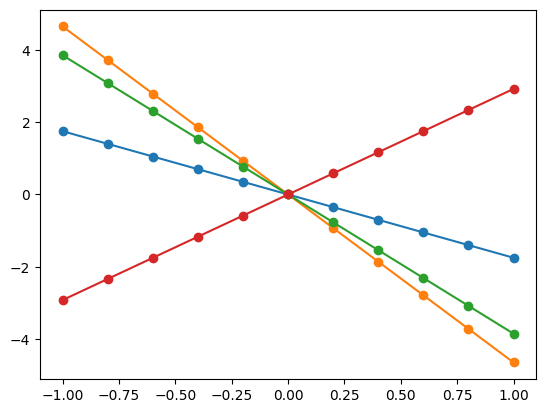

In [4]:
plot(discretization, [gen_affine_curve(discretization)["curve"] for _ in range(4)])

In [5]:
def gen_dataset(discretization, generator, nb=1000):
    return [generator(discretization) for _ in range(nb)]

In [6]:
dataset = gen_dataset(discretization, gen_affine_curve, nb=1000)
dataset[:4]

[{'curve': tensor([-2.5649, -2.0519, -1.5389, -1.0260, -0.5130,  0.0000,  0.5130,  1.0260,
           1.5389,  2.0519,  2.5649]),
  'parameters': 2.5648915923956803},
 {'curve': tensor([-0.2775, -0.2220, -0.1665, -0.1110, -0.0555,  0.0000,  0.0555,  0.1110,
           0.1665,  0.2220,  0.2775]),
  'parameters': 0.27746852739775285},
 {'curve': tensor([ 3.6639,  2.9312,  2.1984,  1.4656,  0.7328, -0.0000, -0.7328, -1.4656,
          -2.1984, -2.9312, -3.6639]),
  'parameters': -3.663939726101164},
 {'curve': tensor([ 2.6288,  2.1030,  1.5773,  1.0515,  0.5258, -0.0000, -0.5258, -1.0515,
          -1.5773, -2.1030, -2.6288]),
  'parameters': -2.6287820326031364}]

On va créer un auto encodeur qui aurra comme code un vecteur de dimension 1

Créez 2 réseaux:
 - Encoder : 
    - Les données en entrée seront de dimension *vector_size*
    - La donnée en sortie sera de dimension 1 
 - Decoder
    - Les données en entrée seront de dimension 1
    - La donnée en sortie sera de dimension *vector_size* 
    
Prennez l'architecture la plus simple possible dans ce 1 er cas

In [7]:
class Encoder(nn.Module):
    def __init__(self, vector_size):
        super().__init__()
        self.encoder = nn.Linear(vector_size, 1)        
    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, vector_size):
        super().__init__()
        self.decoder = nn.Linear(1, vector_size)

    def forward(self, x):
        return self.decoder(x)

Entrainement du réseau !

Tracez la courbe d'erreur au cours de l'entrainement

In [8]:
def loader(dataset, batch_size=64):
    dataset_copy = dataset.copy()
    random.shuffle(dataset_copy)
    inputs, tensor_a = [], []
    for data in dataset_copy:
        input = data["curve"]
        a = data["parameters"]
        if not isinstance(a, list):
            a = [a]
        inputs.append(torch.Tensor(input))
        tensor_a.append(torch.Tensor(a))
        if len(inputs) >= batch_size:
            yield torch.stack(inputs), torch.Tensor(tensor_a)
            inputs, tensor_a = [], []
        
    if len(inputs) > 0:
        yield torch.stack(inputs), torch.Tensor(tensor_a)  

0 87.80539131164551


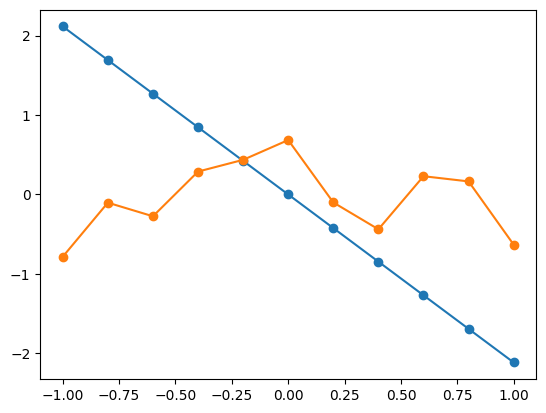

1 83.1420431137085


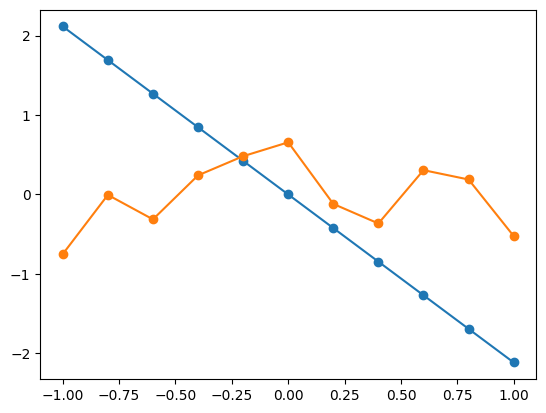

3 74.37980556488037


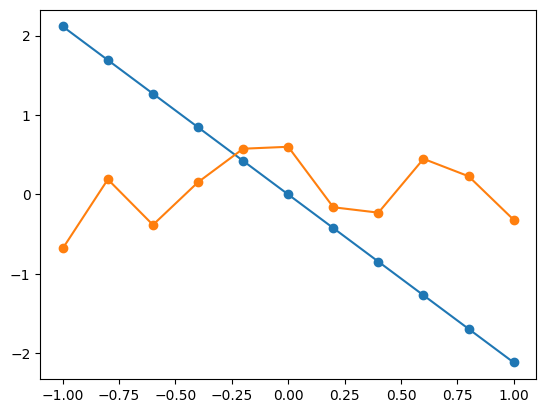

7 61.20563840866089


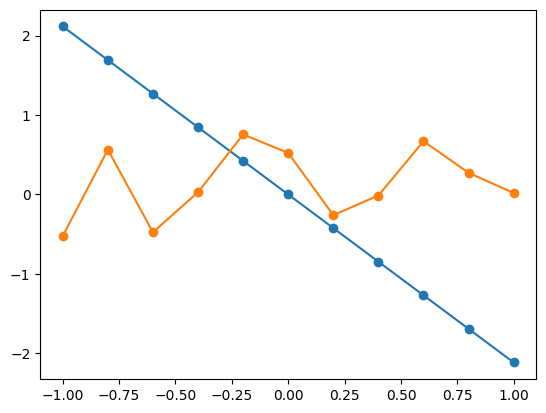

15 47.10442543029785


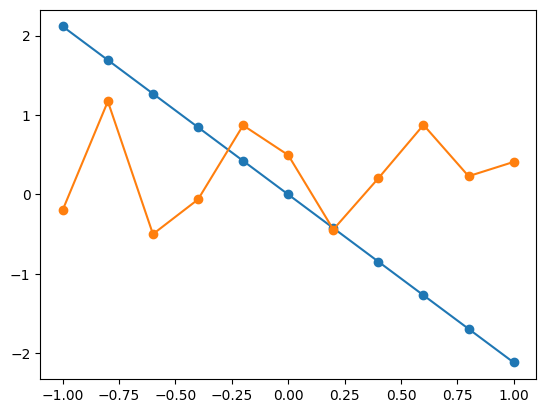

31 33.9306538105011


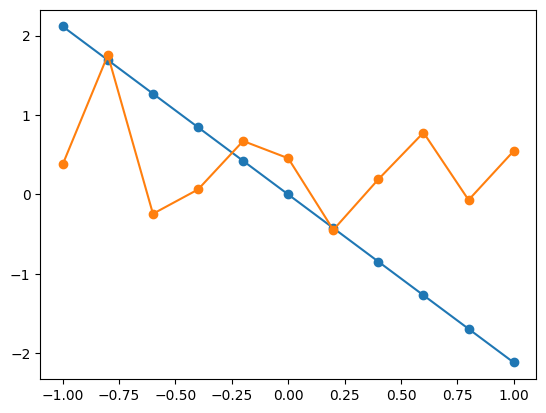

63 18.10582685470581


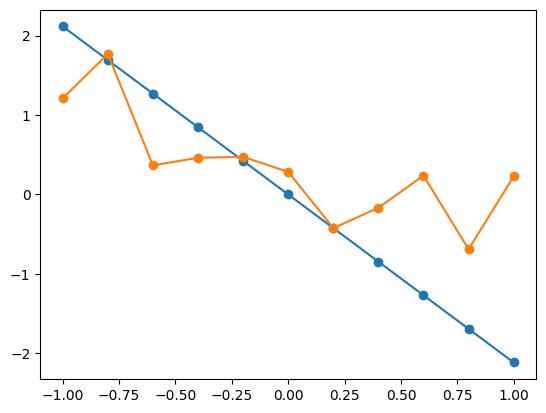

127 5.069227933883667


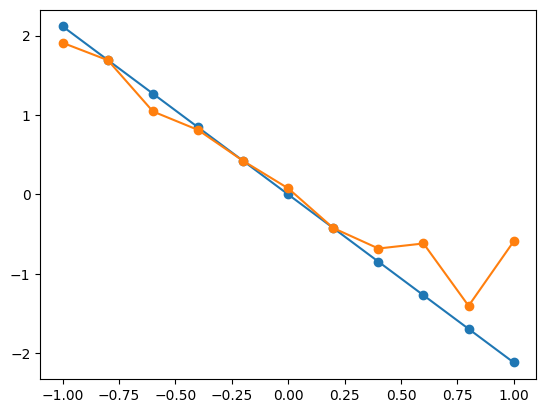

255 0.38219209760427475


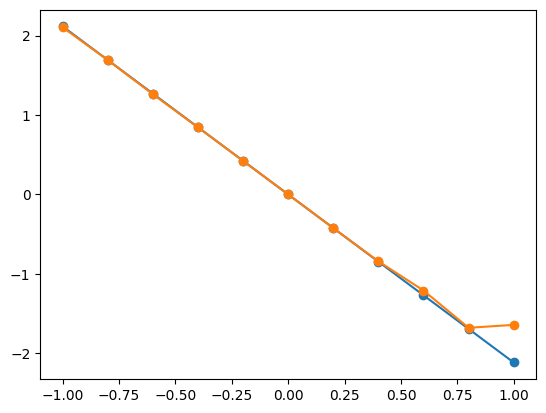

511 2.061705345113296e-05


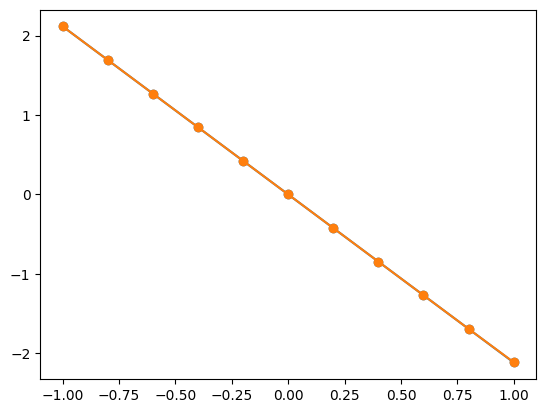

tensor(1.2168e-12, grad_fn=<AddBackward0>)

In [9]:
from math import log2
import torch.optim as optim

vector_size = 11
encoder = Encoder(vector_size)
decoder = Decoder(vector_size)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
loss = torch.nn.MSELoss()

epoch_errors = []
show = gen_affine_curve(discretization)["curve"]
for epoch in range(1000):
    epoch_error = 0
    for input, a in loader(dataset, 128):
        # On annule les gradients
        optimizer.zero_grad()
        # On fait la forward-pass
        z = encoder(input)
        output = decoder(z)
        # On calcule la loss associée
        loss_value = loss(output, input) + loss(z.reshape(-1), a.reshape(-1))
        # On calcule les gradients
        loss_value.backward()
        # On indique à l'optimiser de faire son travail => Mise a jour du réseau ici
        optimizer.step()
        epoch_error += float(loss_value)
    if int(log2(epoch+1)) == log2(epoch+1):
        print(epoch, epoch_error)
        input = show
        with torch.no_grad():
            z = encoder(input)
            output = decoder(z)
        plot(discretization, [input, output])
    epoch_errors.append(epoch_error)
loss_value

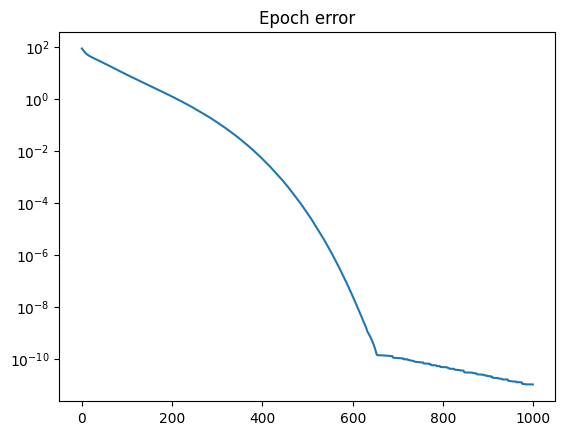

In [10]:
import matplotlib.pyplot as plt

plt.plot(epoch_errors)
plt.title("Epoch error")
plt.yscale("log");

http://127.0.0.1:8888/lab?token=89ee14201aa2c39e0c1de419c462f7f148582f3741c5561bAffichez sur un graphe l'input X et sa reconstruction par l'autoencodeur

In [11]:
sample = gen_affine_curve(discretization)
curve = sample["curve"]
a = sample["parameters"]
with torch.no_grad():
    z = encoder(curve)
(a, z)

(3.8178804101016084, tensor([3.8179]))

Obtient-on $z = a$ ? 
- Si oui : Pourquoi ?
- Si non : Comment inclure cette contrainte ?

On recommence en incluant la contrainte $z = a$

In [12]:
def gen_affine_bias_curve(discretization):
    a = 10*(random.random() -0.5)
    b = 10*(random.random() -0.5)
    return {"curve": torch.Tensor([a*x+b for x in discretization]), "parameters": [a,b]}

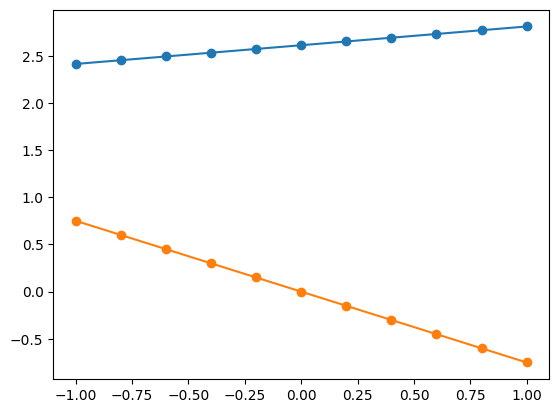

error=tensor(7.1826), (a=0.19860918088097756, z=tensor([-0.7508])), b=2.611906482106966


In [13]:
sample = gen_affine_bias_curve(discretization)
curve = sample["curve"]
a, b = sample["parameters"]
with torch.no_grad():
    z = encoder(curve)
    new_curve = decoder(z)
    error = loss(curve, new_curve)
plot(discretization,[curve, new_curve])
print(f"{error=}, ({a=}, {z=}), {b=}")

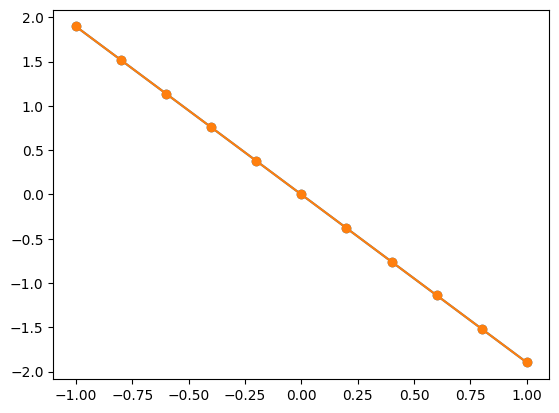

error=tensor(4.3860e-13), (a=-1.8973155902449657, z=tensor([-1.8973]))


In [14]:
sample = gen_affine_curve(discretization)
curve = sample["curve"]
a = sample["parameters"]
with torch.no_grad():
    z = encoder(curve)
    new_curve = decoder(z)
    error = loss(curve, new_curve)
plot(discretization,[curve, new_curve])
print(f"{error=}, ({a=}, {z=})")

Maintenant que se passe-t-il quand on présente au réseau une discrétisation d'une fonction du type $$ g(x) = \sin(b \pi x) $$

Codez la fonction gen_sinus_curve, qui prend en paramètre la discrétisation, sample un b random entre 1 et 10 et retourne le vecteur G associé à la discrétisation de $g(x)$.

In [15]:
from math import pi, sin
def gen_sinus_curve(discretization):
    b = 1+9*random.random()
    return {"curve": torch.Tensor([sin(b*pi*x) for x in discretization]), "parameters": b}

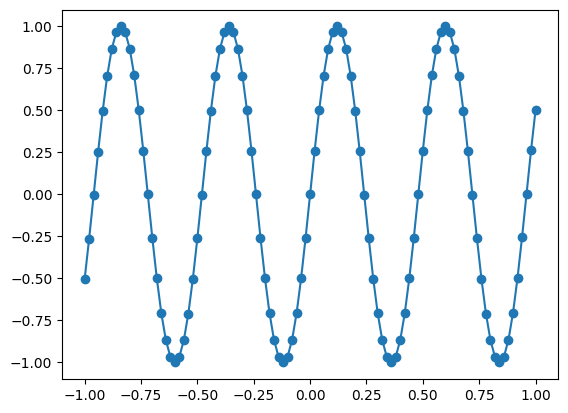

In [16]:
discretization = discretize_space(size=101)
sample = gen_sinus_curve(discretization)
plot(discretization, [sample["curve"]])

In [17]:
class EncoderSinus(nn.Module):
    def __init__(self, vector_size):
        super().__init__()
        s1, s2, s3, s4 = vector_size
        self.l1 = nn.Linear(s1, s2)        
        self.l2 = nn.Linear(s2, s3)        
        self.l3 = nn.Linear(s3, s4)        
    def forward(self, x):
        return nn.Sequential(
            self.l1,
            nn.ReLU(),
            self.l2,
            nn.ReLU(),
            self.l3,        
        )(x)

class DecoderSinus(nn.Module):
    def __init__(self, vector_size):
        super().__init__()
        s1, s2, s3, s4 = vector_size
        self.l1 = nn.Linear(s2, s1)        
        self.l2 = nn.Linear(s3, s2)        
        self.l3 = nn.Linear(s4, s3)        
    def forward(self, x):
        return nn.Sequential(
            self.l3,
            nn.ReLU(),
            self.l2,
            nn.ReLU(),
            self.l1 ,
         )(x)


0 4.946980774402618
error=tensor(0.4827)


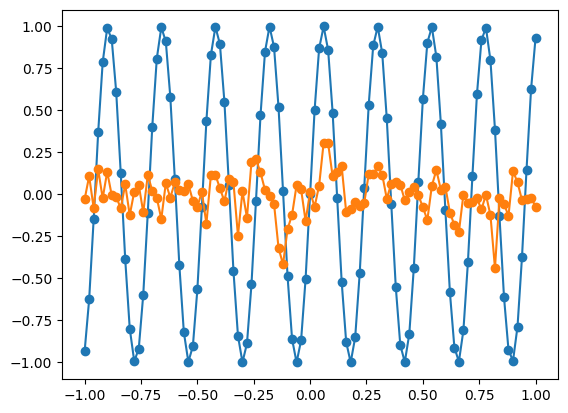

1 4.76296266913414
error=tensor(0.4633)


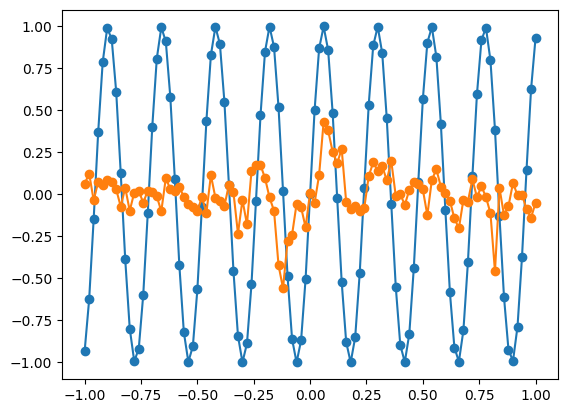

3 4.385470807552338
error=tensor(0.4175)


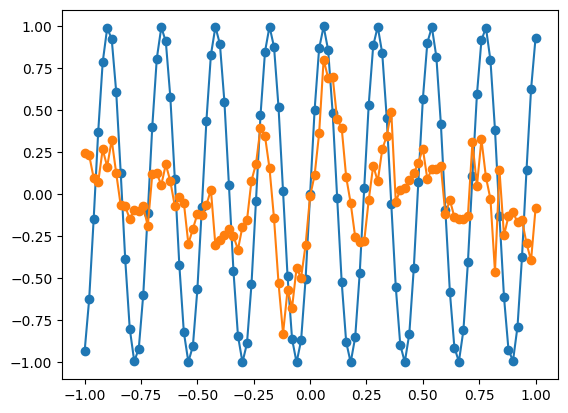

7 3.757161110639572
error=tensor(0.4312)


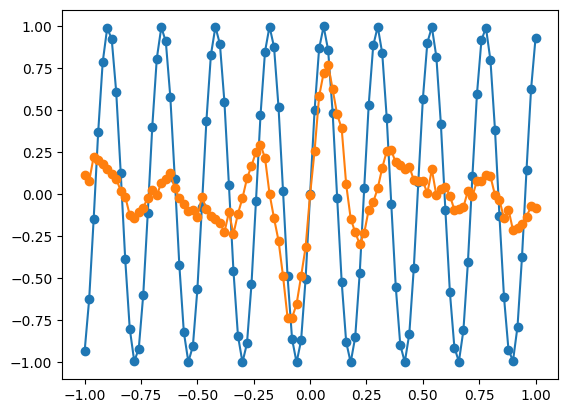

15 3.1804771721363068
error=tensor(0.4576)


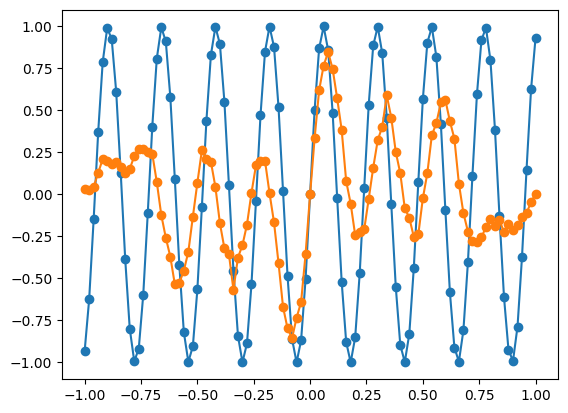

31 2.480235278606415
error=tensor(0.5921)


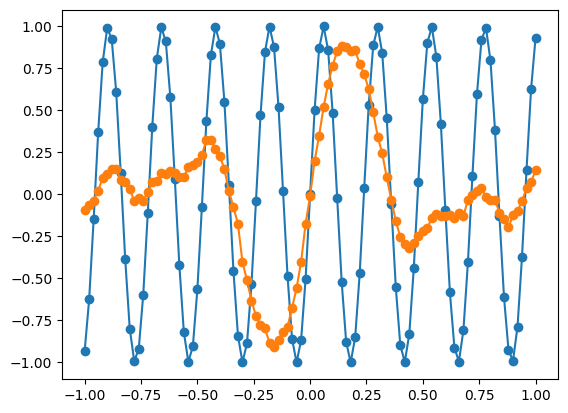

63 2.2551223188638687
error=tensor(0.3699)


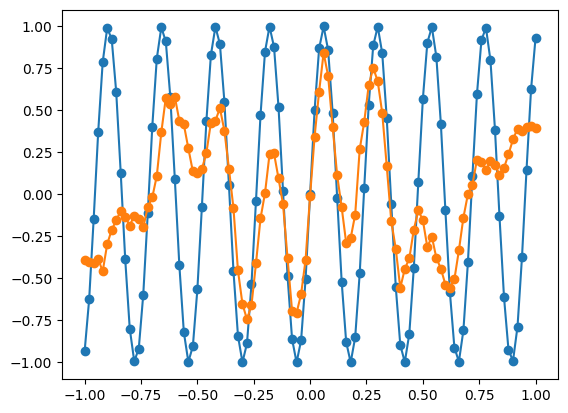

127 1.5107409358024597
error=tensor(0.0274)


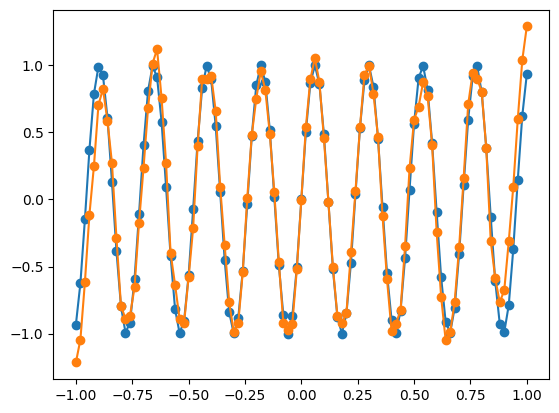

255 0.6785425208508968
error=tensor(0.0240)


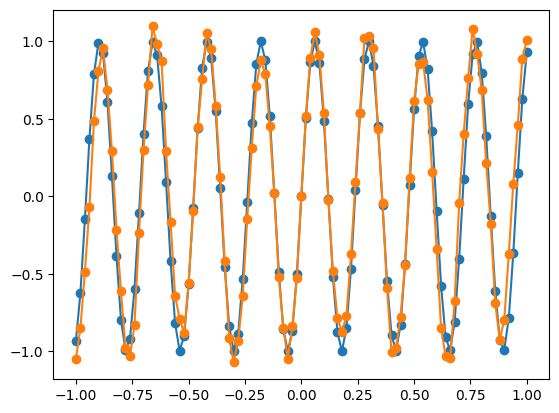

511 0.21155137568712234
error=tensor(0.0031)


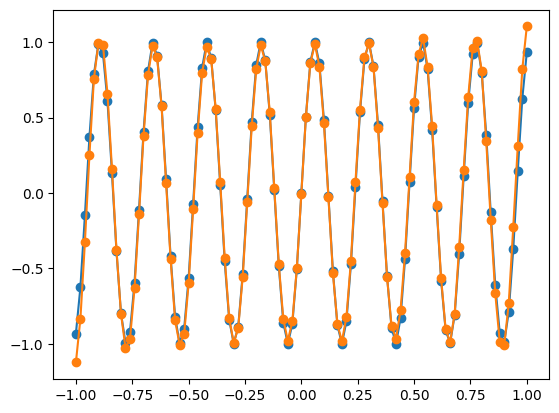

tensor(0.0050, grad_fn=<MseLossBackward0>)

In [18]:
from math import log2
import torch.optim as optim

vector_size = [101,40,10,1]
discretization = discretize_space(size=vector_size[0])
encoder_sinus = EncoderSinus(vector_size)
decoder_sinus = DecoderSinus(vector_size)
optimizer = optim.Adam(list(encoder_sinus.parameters()) + list(decoder_sinus.parameters()))
loss = torch.nn.MSELoss()

epoch_errors = []
show = gen_sinus_curve(discretization)["curve"]
dataset_sinus = gen_dataset(discretization, gen_sinus_curve, 1000)
for epoch in range(1000):
    epoch_error = 0
    for input, a in loader(dataset_sinus, 100):
        # On annule les gradients
        optimizer.zero_grad()
        # On fait la forward-pass
        z = encoder_sinus(input)
        output = decoder_sinus(z)
        # On calcule la loss associée
        loss_value = loss(output, input)
        # On calcule les gradients
        loss_value.backward()
        # On indique à l'optimiser de faire son travail => Mise a jour du réseau ici
        optimizer.step()
        epoch_error += float(loss_value)
    if int(log2(epoch+1)) == log2(epoch+1):
        print(epoch, epoch_error)
        input = show
        with torch.no_grad():
            z = encoder_sinus(input)
            output = decoder_sinus(z)
            error = loss(output, input)
        print(f"{error=}")
        plot(discretization, [input, output])
    epoch_errors.append(epoch_error)
    if epoch_error < 1e-5:
        break
loss_value

Affichez sur un graphe, G et sa reconstruction par l'autoencodeur

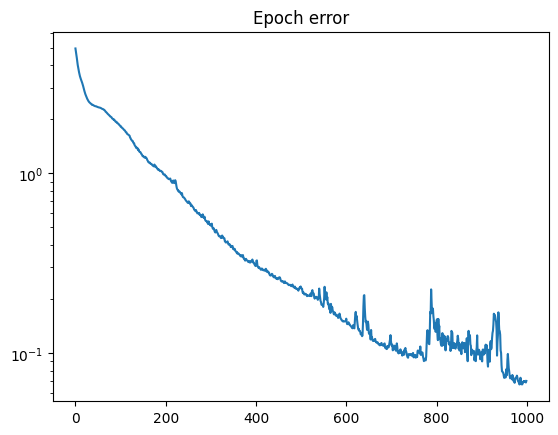

In [19]:
import matplotlib.pyplot as plt

plt.plot(epoch_errors)
plt.title("Epoch error")
plt.yscale("log");

Calculez les distances entre l'entrée et la sortie

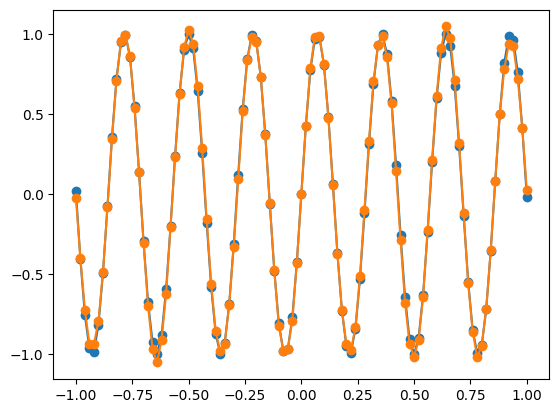

error=tensor(0.0005), (a=7.00585689824817, z=tensor([6.0084]))


In [20]:
sample = gen_sinus_curve(discretization)
curve = sample["curve"]
a = sample["parameters"]
with torch.no_grad():
    z = encoder_sinus(curve)
    new_curve = decoder_sinus(z)
    error = loss(curve, new_curve)
plot(discretization,[curve, new_curve])
print(f"{error=}, ({a=}, {z=})")

Vous venez de découvrir l'un des usages des autoencodeurs : La détection d'anomalies

Est-ce que la même architecture peut encoder des fonctions affine *et* des sinus?

- Que changer ?
- Implémentez !

0 16.43906271457672
error=tensor(0.4980)


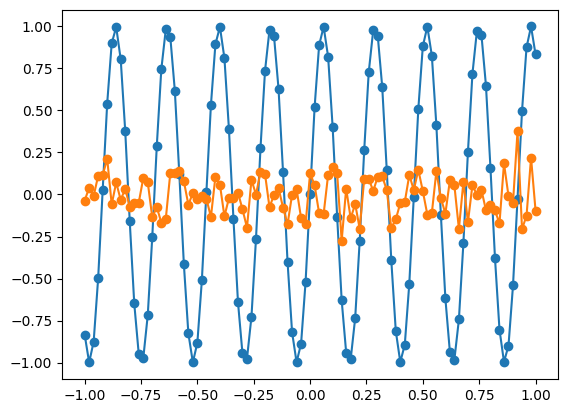

error=tensor(0.4213)


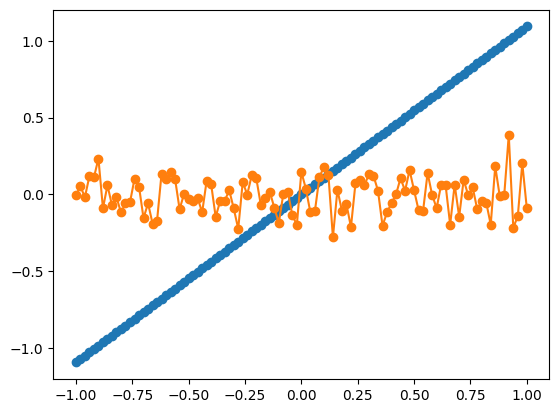

1 15.221943974494934
error=tensor(0.4955)


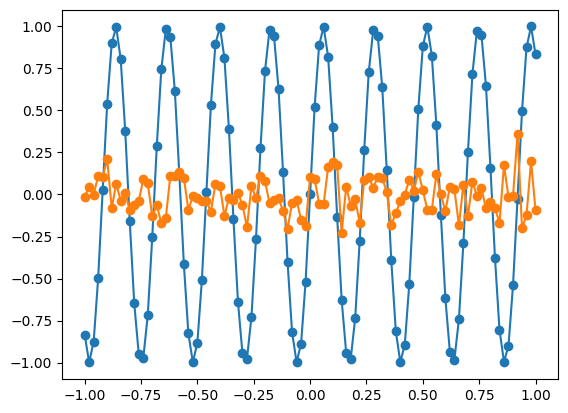

error=tensor(0.3837)


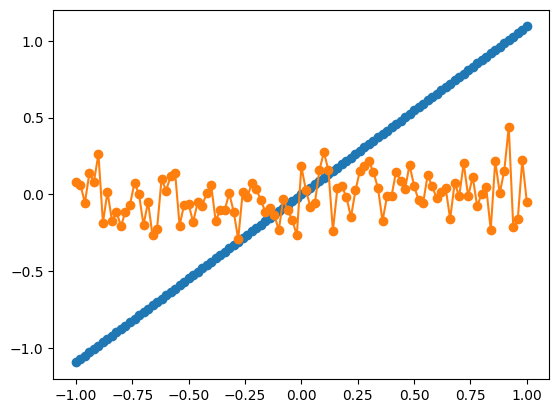

3 8.386533796787262
error=tensor(0.5069)


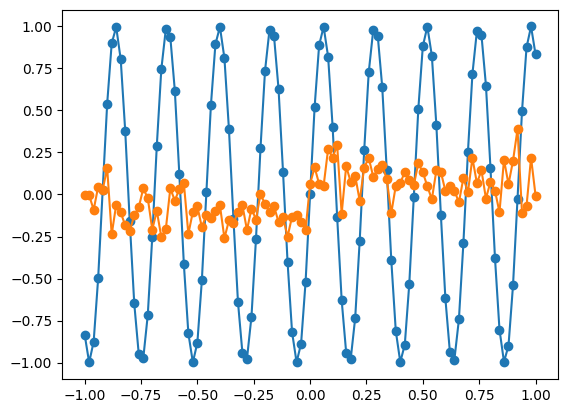

error=tensor(0.1747)


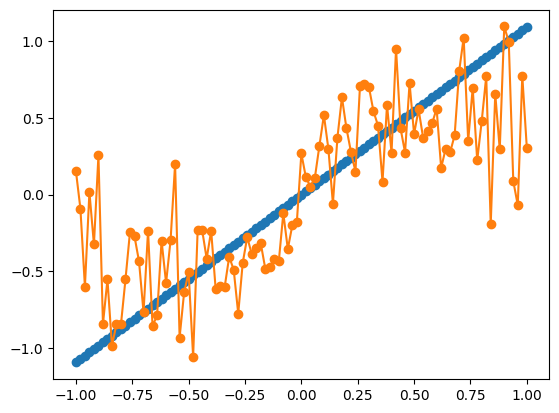

7 2.5363144129514694
error=tensor(0.4790)


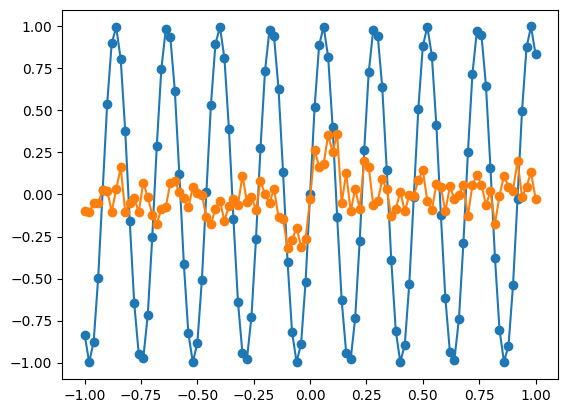

error=tensor(0.0155)


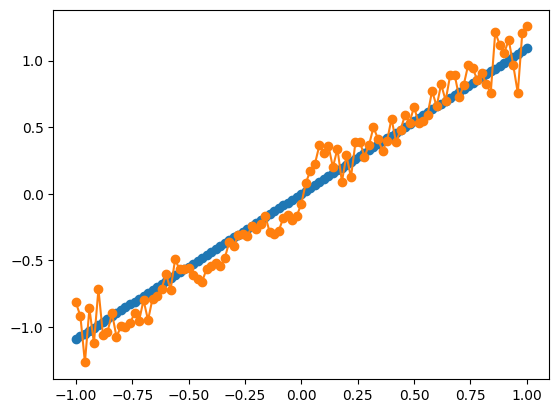

15 2.1866424530744553
error=tensor(0.4402)


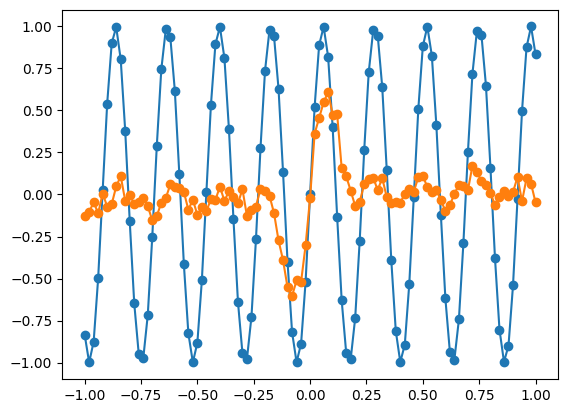

error=tensor(0.0111)


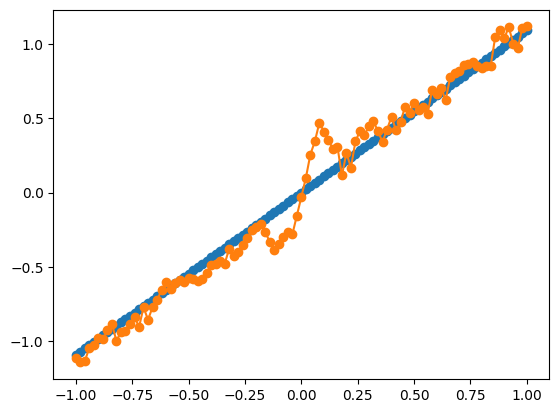

31 1.853991225361824
error=tensor(0.4263)


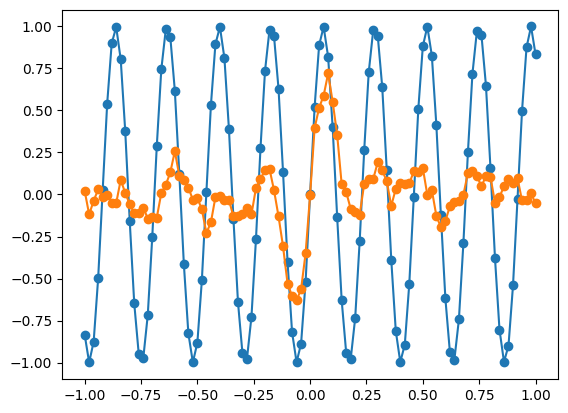

error=tensor(0.0129)


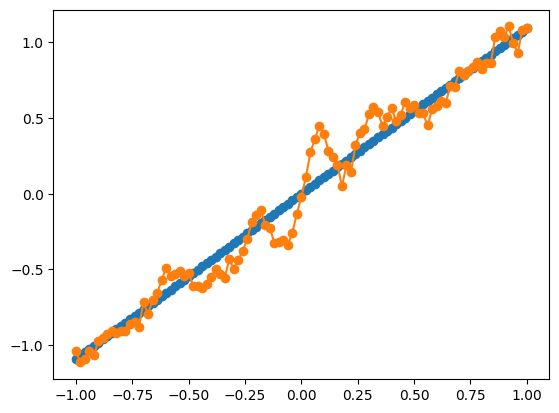

63 1.1097587421536446
error=tensor(0.2983)


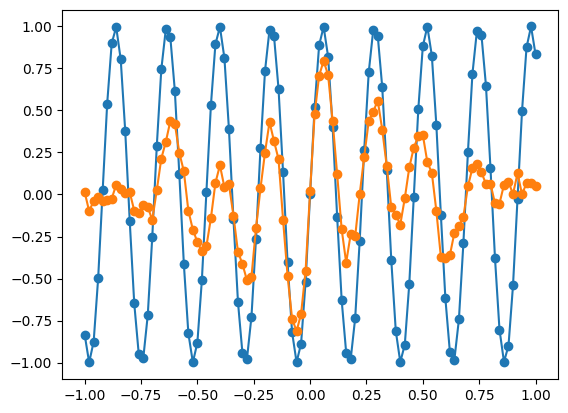

error=tensor(0.0103)


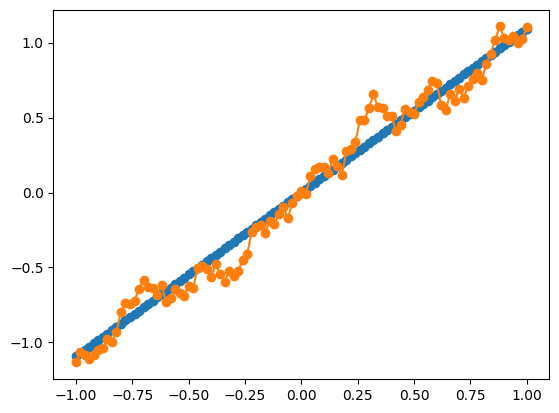

127 0.4674232415854931
error=tensor(0.0667)


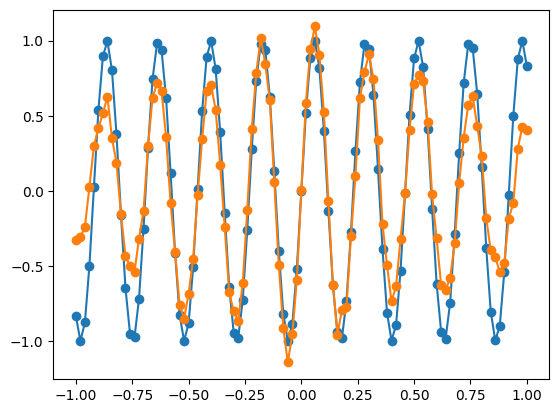

error=tensor(0.0085)


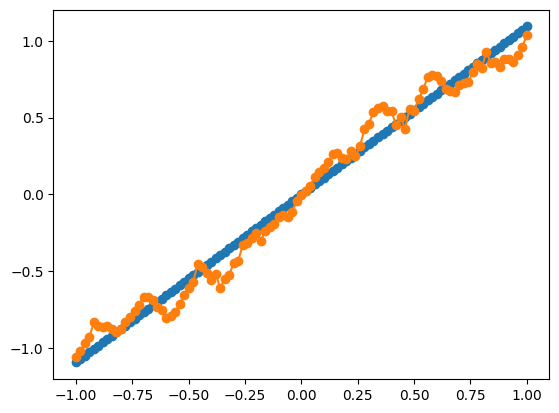

255 0.18728188425302505
error=tensor(0.0065)


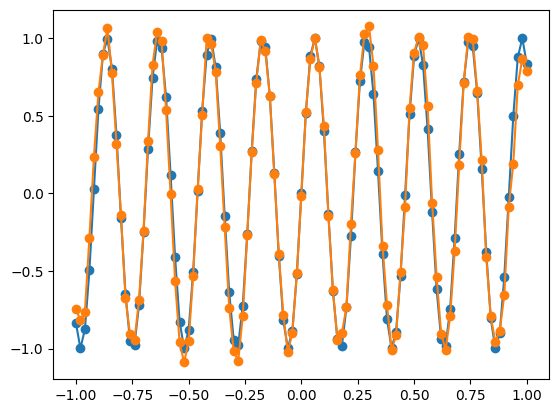

error=tensor(0.0011)


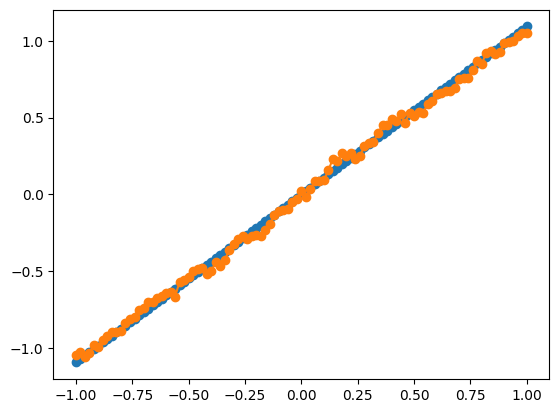

455 0.07319226837716997
error=tensor(0.0024)


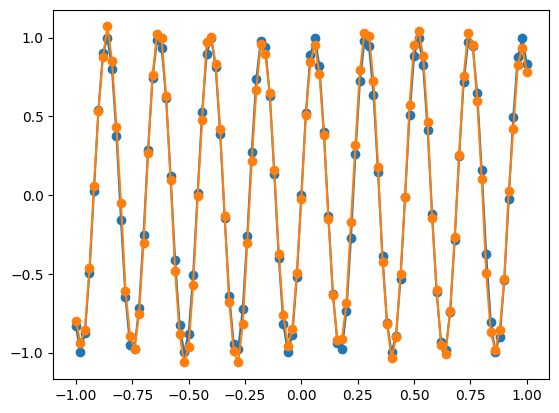

error=tensor(0.0002)


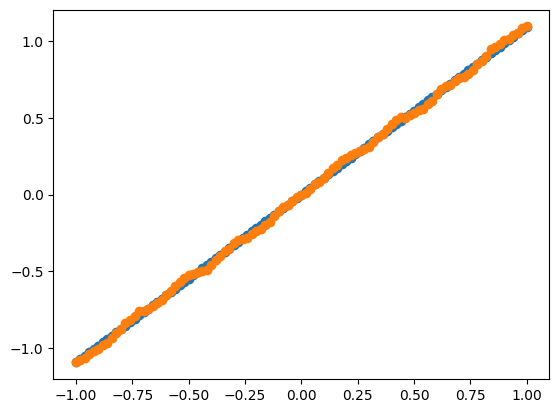

511 0.05648186360485852
error=tensor(0.0030)


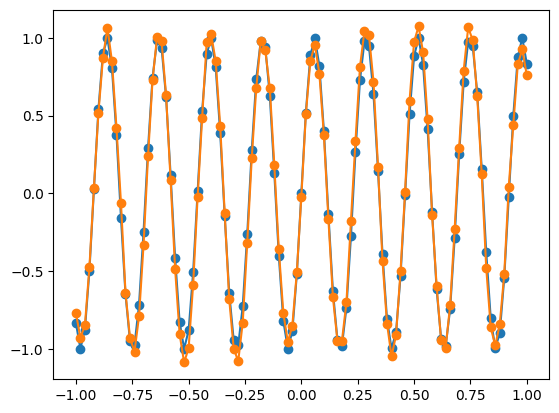

error=tensor(0.0001)


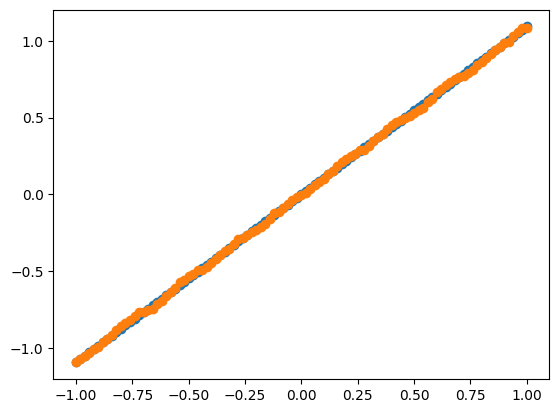

711 0.03206527838483453
error=tensor(0.0025)


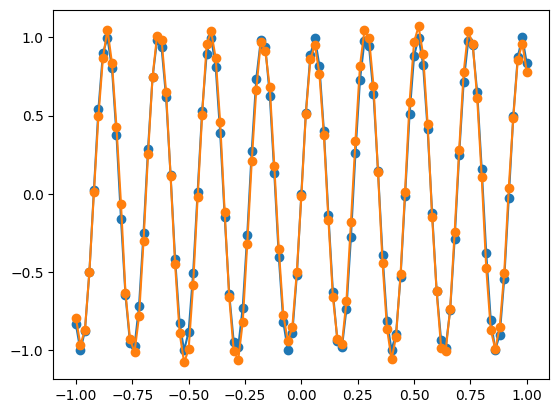

error=tensor(0.0001)


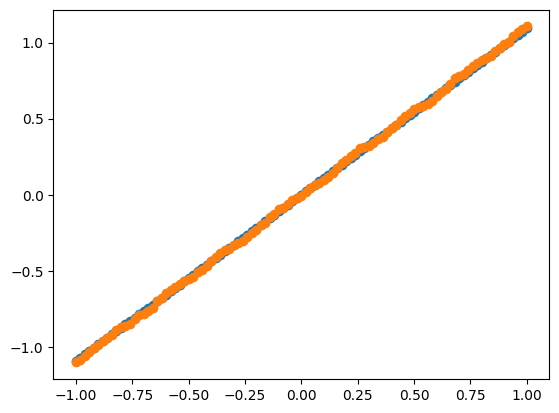

911 0.018405713723041117
error=tensor(0.0015)


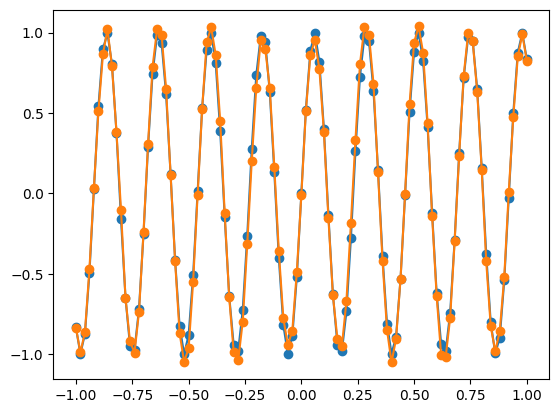

error=tensor(4.7875e-05)


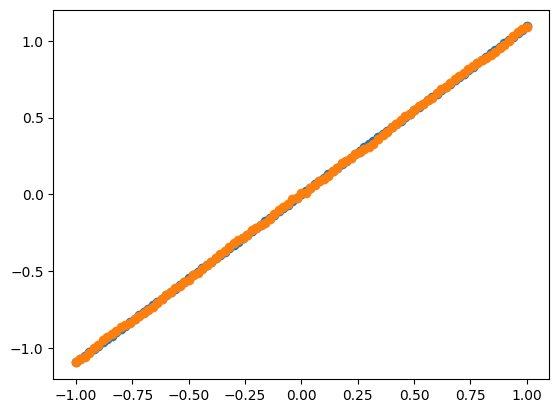

tensor(0.0016, grad_fn=<MseLossBackward0>)

In [21]:
from math import log2
import torch.optim as optim

vector_size = [101,40,10,2]
discretization = discretize_space(size=vector_size[0])
encoder_sinus = EncoderSinus(vector_size)
decoder_sinus = DecoderSinus(vector_size)
optimizer = optim.Adam(list(encoder_sinus.parameters()) + list(decoder_sinus.parameters()))
loss = torch.nn.MSELoss()

epoch_errors = []
shows = [ 
        gen_sinus_curve(discretization)["curve"],
    gen_affine_curve(discretization)["curve"]
]
dataset_sinus = gen_dataset(discretization, gen_sinus_curve, 500) + gen_dataset(discretization, gen_affine_curve, 500)
last_show = 0
for epoch in range(1000):
    epoch_error = 0
    for input, a in loader(dataset_sinus, 100):
        # On annule les gradients
        optimizer.zero_grad()
        # On fait la forward-pass
        z = encoder_sinus(input)
        output = decoder_sinus(z)
        # On calcule la loss associée
        loss_value = loss(output, input)
        # On calcule les gradients
        loss_value.backward()
        # On indique à l'optimiser de faire son travail => Mise a jour du réseau ici
        optimizer.step()
        epoch_error += float(loss_value)
    if int(log2(epoch+1)) == log2(epoch+1) or epoch - last_show >= 200:
        last_show = epoch
        print(epoch, epoch_error)
        for show in shows:
            input = show
            with torch.no_grad():
                z = encoder_sinus(input)
                output = decoder_sinus(z)
                error = loss(output, input)
            print(f"{error=}")
            plot(discretization, [input, output])
    epoch_errors.append(epoch_error)
    if epoch_error < 1e-5:
        break
loss_value

Maintenant dans l'entrainement incluez des fonctions affines et des sinus. 

Changez $z$ vous n'avez plus la contrainte dimension = 1.

Entrainez!

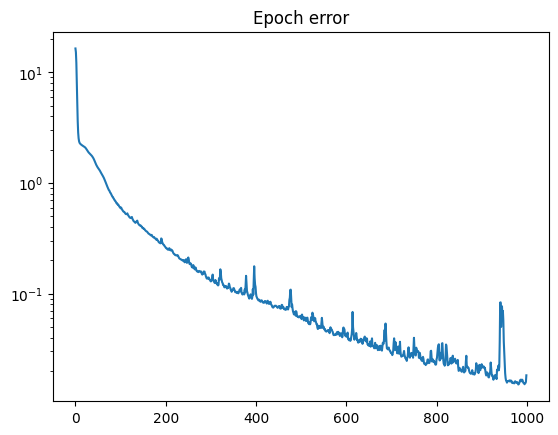

In [22]:
import matplotlib.pyplot as plt

plt.plot(epoch_errors)
plt.title("Epoch error")
plt.yscale("log");

Avec cette architecture je veux maintenant que vous puissiez me dire si c'est un sinus ou une fonction affine :
 - On fait de la classification avec ce réseau

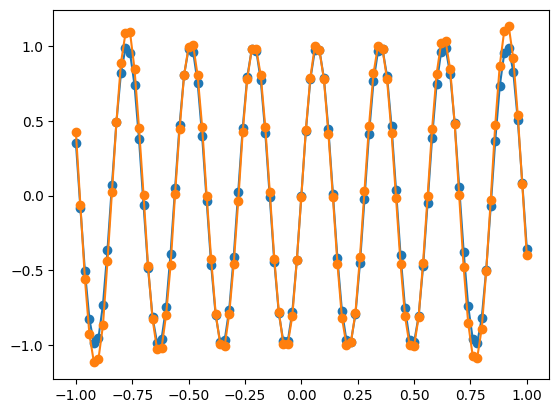

error=tensor(0.0037), (a=7.115537157748883, z=tensor([-11.8536,  14.6059]))


In [23]:
sample = gen_sinus_curve(discretization)
curve = sample["curve"]
a = sample["parameters"]
with torch.no_grad():
    z = encoder_sinus(curve)
    new_curve = decoder_sinus(z)
    error = loss(curve, new_curve)
plot(discretization,[curve, new_curve])
print(f"{error=}, ({a=}, {z=})")

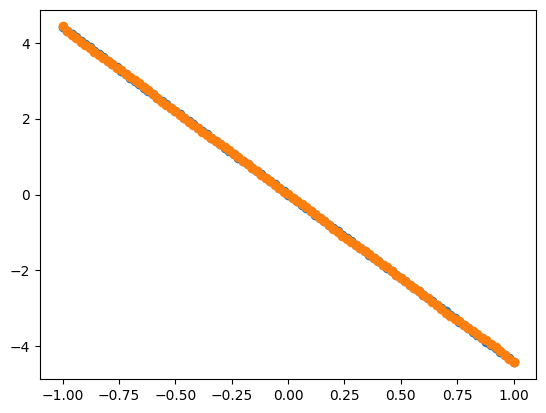

error=tensor(0.0002), (a=-4.40415301071941, z=tensor([22.5422, 33.8094]))


In [24]:
sample = gen_affine_curve(discretization)
curve = sample["curve"]
a = sample["parameters"]
with torch.no_grad():
    z = encoder_sinus(curve)
    new_curve = decoder_sinus(z)
    error = loss(curve, new_curve)
plot(discretization,[curve, new_curve])
print(f"{error=}, ({a=}, {z=})")

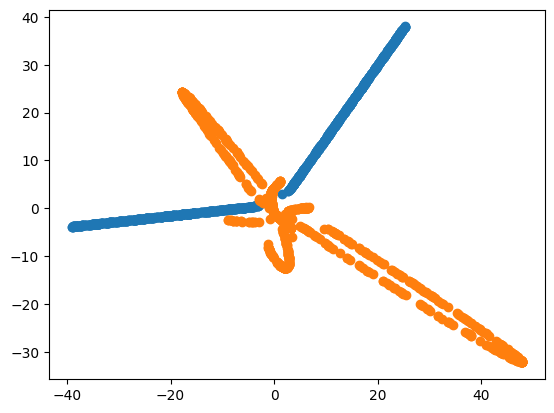

In [25]:
nbpts=1000
x,y = [], []
for _ in range(nbpts):
    sample = gen_affine_curve(discretization)
    curve = sample["curve"]
    a = sample["parameters"]
    with torch.no_grad():
        z = encoder_sinus(curve)
    x.append(float(z[0]))
    y.append(float(z[1]))
plt.plot(x, y, marker='o', linestyle="")
x,y = [], []
for _ in range(nbpts):
    sample = gen_sinus_curve(discretization)
    curve = sample["curve"]
    a = sample["parameters"]
    with torch.no_grad():
        z = encoder_sinus(curve)
    x.append(float(z[0]))
    y.append(float(z[1]))
plt.plot(x, y, marker='o', linestyle="")
plt.show();